## Libraries

In [1]:
import numpy as np

np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import os, subprocess

import cooler
import cooltools.lib.plotting
from cooltools.api.saddle import saddle_strength

import cooltools
import bioframe
import multiprocess as mp

from tqdm import tqdm
import multiprocessing

import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/cta/users/vkaya/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/cta/users/vkaya/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


## POLR2A Chip-SEq Process & EVD

In [2]:
resolution = 100_000
NPROC = 24

In [3]:
clr = cooler.Cooler(
    f"/cta/users/vkaya/gnn/matrix/matrix/t0_q30.mcool::/resolutions/{resolution}"
)

view_df = pd.DataFrame(
    {
        "chrom": clr.chromnames,
        "start": 0,
        "end": clr.chromsizes.values,
        "name": clr.chromnames,
    }
)
bins = clr.bins()[:]

import bbi

bw = bins[["chrom", "start", "end"]]
stacks = bbi.stackup(
    "/cta/users/vkaya/hi-c/work/hela/notebooks/ab/ENCFF144IVU.bigWig",
    bw["chrom"],
    bw["start"],
    bw["end"],
    bins=1,
)
from sklearn.preprocessing import MinMaxScaler

x_norm = MinMaxScaler().fit_transform(stacks)
bw.loc[:, "BW"] = x_norm
samples = [0, 12, 30, 60]
eigen_data = []
expected_ = []
n_eig = 1

from tqdm import tqdm

pbar = tqdm(total=len(samples))
for sample in samples:
    clr = cooler.Cooler(
        f"/cta/users/vkaya/gnn/matrix/matrix/t{sample}_q30.mcool::/resolutions/{resolution}"
    )

    map_ = mp.Pool(NPROC).map

    cis_eigs = cooltools.eigs_cis(
        clr, bw, view_df=view_df, n_eigs=n_eig, map=map_, sort_metric="pearsonr"
    )
    eigen_data.append(cis_eigs)

    expected = cooltools.expected_cis(clr=clr, view_df=view_df, nproc=NPROC)
    expected_.append(expected)
    pbar.update(1)

/tmp/ipykernel_38330/3633648644.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bw.loc[:, "BW"] = x_norm
100%|██████████| 4/4 [01:25<00:00, 20.35s/it]

In [8]:
for sample, ev in zip(samples, eigen_data):
    ev[1].to_csv(f"e1_t{sample}.csv", index=False)

## Compartment Strength

In [4]:
Q_LO = 0.050
Q_HI = 0.975

N_GROUPS = 50

min_diag = 2
max_diag = 10_000_000 // resolution

In [5]:
saddleData = []

for i, sample in enumerate(samples):
    print(sample, flush=True)
    track = eigen_data[0][1][["chrom", "start", "end", "E1"]]
    interaction_sum, interaction_count = cooltools.saddle(
        cooler.Cooler(
            f"/cta/users/vkaya/gnn/matrix/matrix/t{sample}_q30.mcool::/resolutions/{resolution}"
        ),
        expected_[i],
        track,
        "cis",
        n_bins=N_GROUPS,
        qrange=(Q_LO, Q_HI),
        view_df=view_df,
        trim_outliers=True,
        min_diag=min_diag,
        max_diag=max_diag,
    )
    saddleData.append((interaction_sum, interaction_count))

0
12
30
60


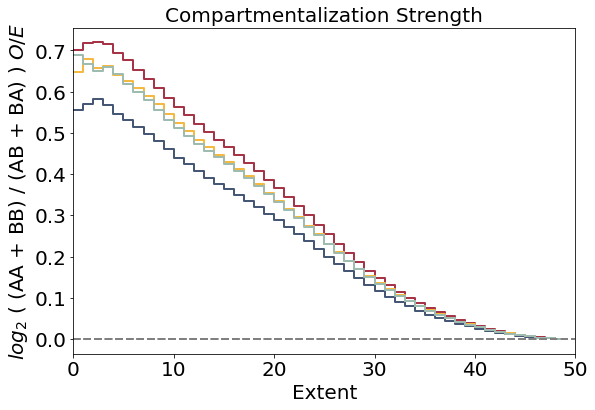

In [38]:
ss = "${O/E}$"
ss_log2 = "$log_{2}$"

plt.figure(figsize=(9,6))

s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']
for interaction_tup, s_color in zip(saddleData, s_colors):
    x = np.arange(N_GROUPS)
    plt.step(
        x,
        np.log2(saddle_strength(interaction_tup[0], interaction_tup[1])),
        where="pre",
        color=s_color,
        lw=2,
    )

    plt.xlabel("Extent", fontsize=20)
    plt.ylabel(f"{ss_log2} ( (AA + BB) / (AB + BA) ) {ss}", fontsize=20)
    plt.title("Compartmentalization Strength", fontsize=20)
    plt.axhline(0, c="grey", ls="--", lw=2)
    plt.xlim(0, len(x))
    plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("compartmentalization_strength.svg",  bbox_inches="tight")

## log2 FCs

aa: 0.07954844533416393, ab: -0.07704589529024918, ba: -0.07704589529024919, bb: 0.018510752091717323
aa: 0.07495765534202127, ab: -0.057683983506596676, ba: -0.05768398350659669, bb: -0.01353229406745538
aa: 0.07845433148562189, ab: -0.04668218472147458, ba: -0.046682184721474576, bb: -0.01980543552681882


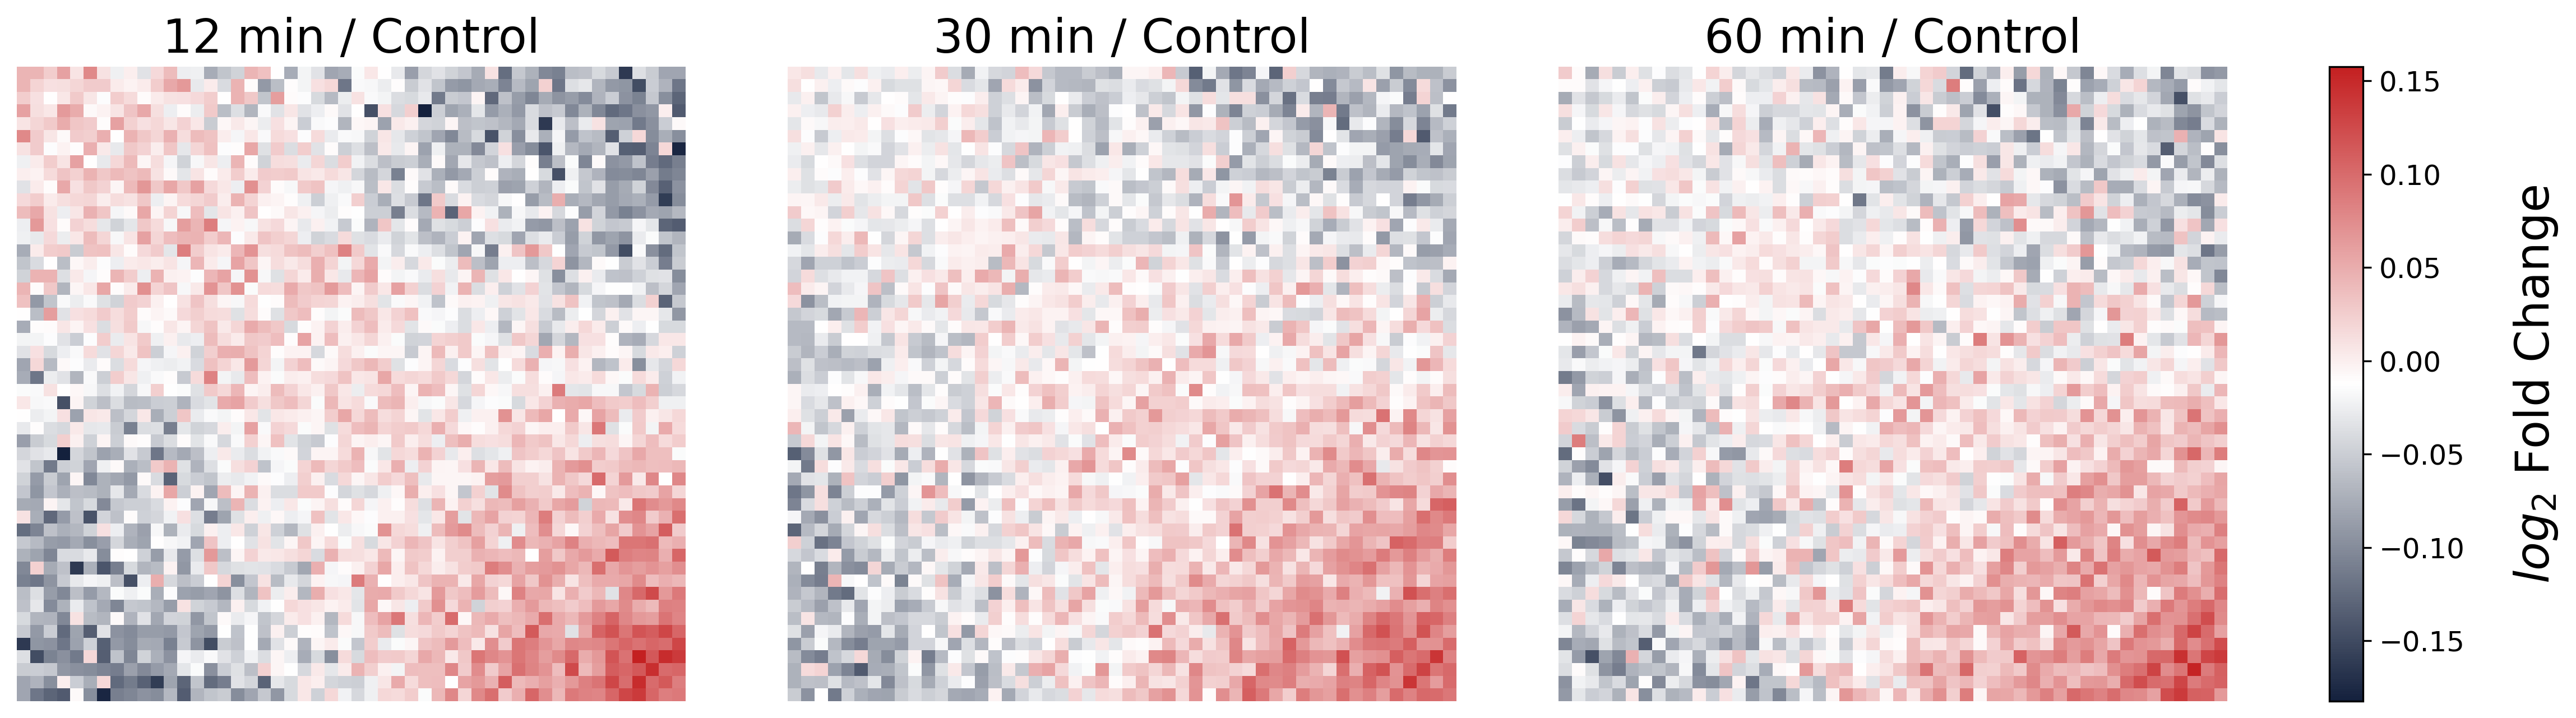

In [111]:
fc_ = []

min_ = []
max_ = []

corners_min = 10
corners_max = N_GROUPS - corners_min

from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)



plt.rcParams["figure.dpi"] = 300
titles = ["12 min / Control", "30 min / Control", "60 min / Control"]
S_C_c = saddleData[0][0] / saddleData[0][1]
for j in [1, 2, 3]:
    S_C_uv = saddleData[j][0] / saddleData[j][1]
    fc = np.log2(S_C_uv / S_C_c)
    fc_.append(fc)
    bb = np.mean(fc[0:corners_min, 0:corners_min])
    ba = np.mean(fc[0:corners_min, corners_max:])
    ab = np.mean(fc[corners_max:, 0:corners_min])
    aa = np.mean(fc[corners_max:, corners_max:])
    print(f"aa: {aa}, ab: {ab}, ba: {ba}, bb: {bb}")
    min_.append(np.min(fc))
    max_.append(np.max(fc))

fig, axs = plt.subplots(
    ncols=4, figsize=(18, 5), gridspec_kw=dict(width_ratios=[4, 4, 4, 0.2])
)

ax_i = 0
for fc in fc_:
    a = sns.heatmap(
        fc, cbar=False, ax=axs[ax_i], vmin=min(min_), vmax=max(max_), cmap=cmp
    )
    a.set(xticklabels=[])
    a.set(yticklabels=[])
    a.tick_params(bottom=False, top=False, left=False, right=False)

    # if ax_i == 0:
    #     a.yaxis.set_ticks(ticks_, labels=ticks_)
    # else:
    #     a.set(yticklabels=[])
    #     a.tick_params(bottom=True, top=False, left=False, right=False)
    # a.xaxis.set_ticks(ticks_, labels=ticks_)
    a.set_title(f"{titles[ax_i]}", fontsize=20)

    ax_i += 1
ss = "${O/E}$"


cbar = fig.colorbar(axs[2].collections[0], cax=axs[ax_i])
cbar.set_label(f"{ss_log2} Fold Change", fontsize=20, labelpad=20)
cbar.ax.tick_params(labelsize=12)

plt.savefig("compartmentalization_strength_fold_change.svg",  bbox_inches="tight")
plt.savefig("compartmentalization_strength_fold_change.png",  bbox_inches="tight", dpi=300)

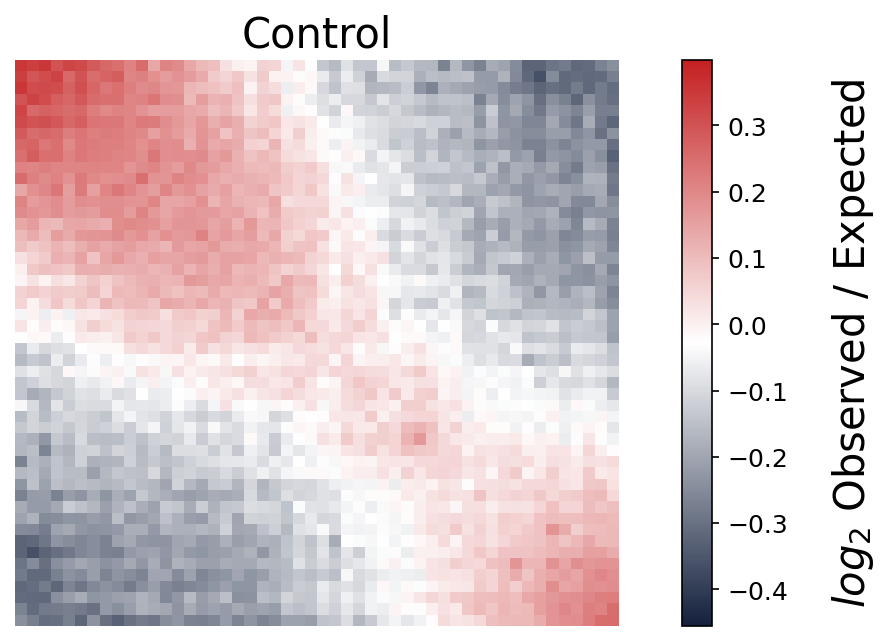

In [112]:
#cmp = sns.color_palette("vlag", as_cmap=True)

from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

plt.rcParams["figure.dpi"] = 150

min_ = []
max_ = []

compertment_wise = {"aa": [], "bb": [], "ab": [], "sample": []}
sample_names = ["Control", "12 min", "30 min", "60 min"]

for j in range(4):
    m = np.log2(saddleData[j][0] / saddleData[j][1])
    min_.append(np.min(m))
    max_.append(np.max(m))

    # m = saddleData[j][0] / saddleData[j][1]
    aa = m[corners_max:, corners_max:]
    bb = m[0:corners_min, 0:corners_min]
    ab = m[corners_max:, 0:corners_min]

    compertment_wise["aa"] += aa.tolist()
    compertment_wise["bb"] += bb.tolist()
    compertment_wise["ab"] += ab.tolist()
    compertment_wise["sample"] += [sample_names[j]] * len(aa.flatten())

fig, axs = plt.subplots(
#    ncols=5, figsize=(24, 5), gridspec_kw=dict(width_ratios=[4, 4, 4, 4, 0.1])
    ncols=2, figsize=(6, 5), gridspec_kw=dict(width_ratios=[4, 0.2])
)
for j in range(1): # range(4): # do not plot for all samples
    a = sns.heatmap(
        np.log2(saddleData[j][0] / saddleData[j][1]),
        cbar=False,
        ax=axs[j],
        vmin=min(min_),
        vmax=max(max_),
        cmap=cmp,
    )
    a.set(xticklabels=[])
    a.set(yticklabels=[])
    a.tick_params(bottom=False, top=False, left=False, right=False)

    # ticks_ = np.arange(1, N_GROUPS + 1, 5)
    # ticks_ += 1
    # if j == 0:
    #     a.yaxis.set_ticks(ticks_, labels=ticks_)
    # else:
    #     a.set(yticklabels=[])
    #     a.tick_params(bottom=True, top=False, left=False, right=False)
    # a.xaxis.set_ticks(ticks_, labels=ticks_)
    
    a.set_title(f"{sample_names[j]}", fontsize=20)

cbar = fig.colorbar(axs[0].collections[0], cax=axs[-1])
cbar.set_label(f"{ss_log2} Observed / Expected", fontsize=20, labelpad=20)
cbar.ax.tick_params(labelsize=12)

plt.savefig("compartments_all.svg",  bbox_inches="tight")
plt.savefig("compartments_all.png",  bbox_inches="tight", dpi=300)


In [113]:
for k, v in compertment_wise.items():
    if k != "sample":
        compertment_wise[k] = np.concatenate(v)

df = pd.DataFrame(compertment_wise)

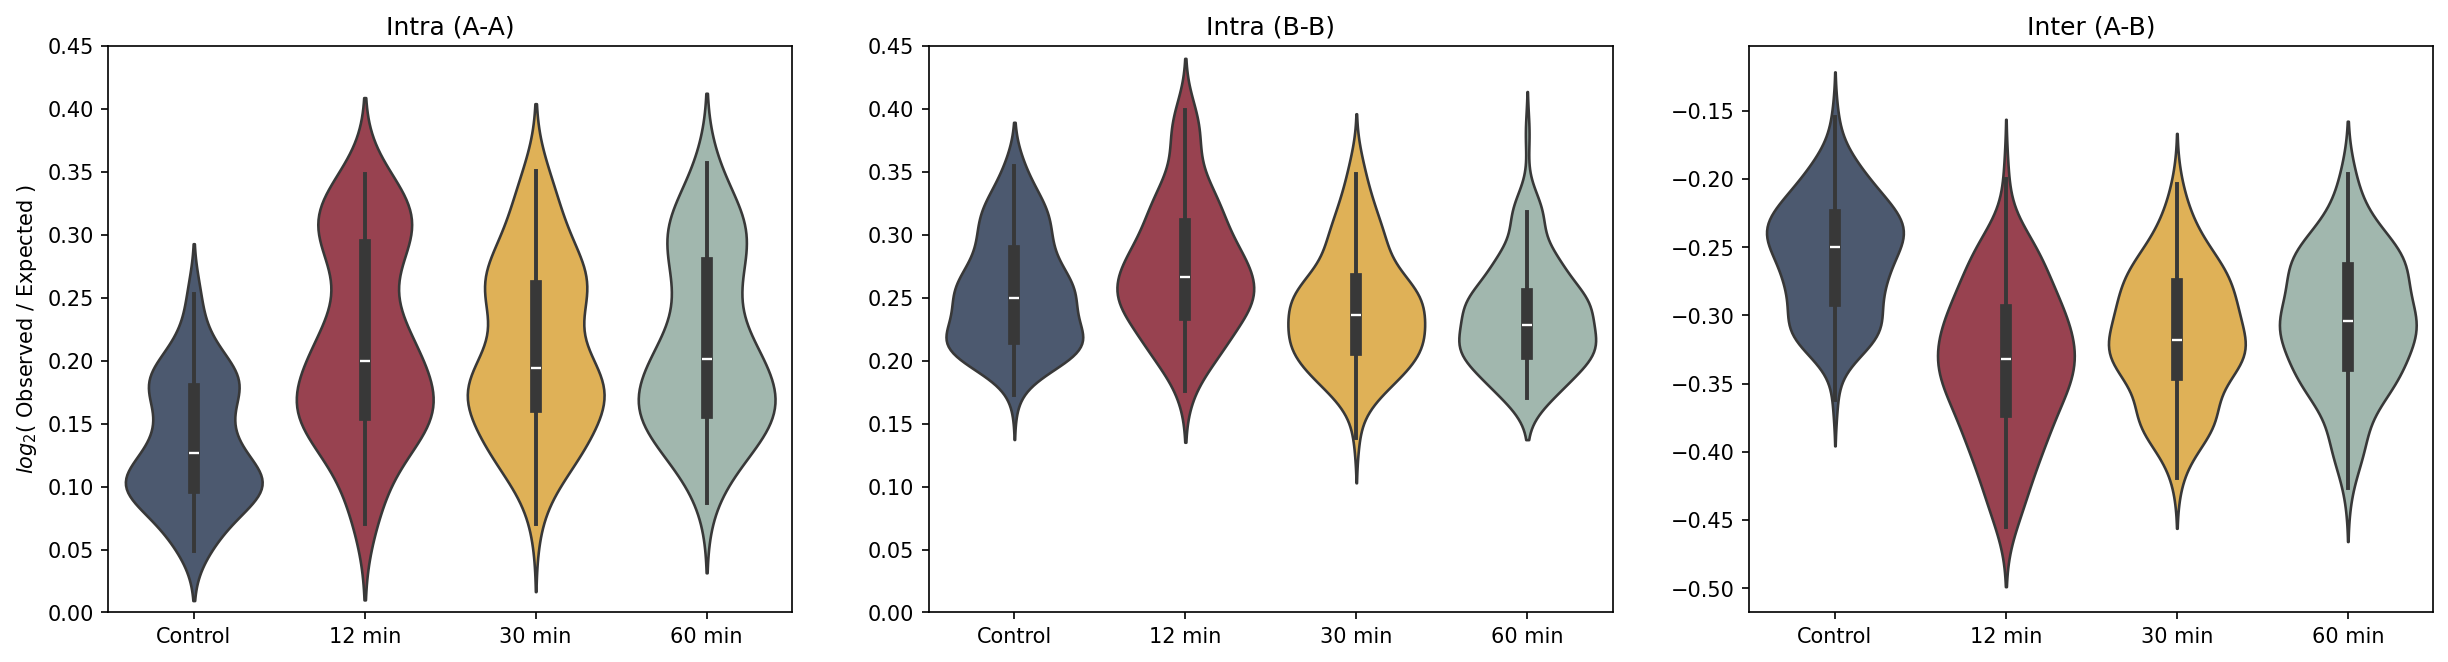

In [119]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']
comp_mapping = {"aa": "Intra (A-A)", "bb": "Intra (B-B)", "ab": "Inter (A-B)"}
for i, k in enumerate(["aa", "bb", "ab"]):
    v = sns.violinplot(df, x="sample", y=k, ax=ax[i], palette=s_colors)
    v.set_title(f"{comp_mapping[k]}")
    if i == 0:
        v.set_ylabel(f"{ss_log2}( Observed / Expected )")
    else:
        v.set_ylabel("")

    if i != 2:
        v.set_ylim(0, 0.45)

    v.set_xlabel("")

plt.savefig("compartments_top20.svg",  bbox_inches="tight")
plt.savefig("compartments_top20.png",  bbox_inches="tight", dpi=300)

In [121]:
df.to_csv("compartments_top20.tsv", index=False, sep="\t")